Cluster Analysis for Pairs Trading

1. Data Preparation
2. k-Means Clustering
3. Hierarchical Clustering
4. Affinity Propagation Clustering
5. Model Performance
6. Pairs Extraction

1. Data Preparation

In [ ]:
#pip install yahoo_fin
import pandas as pd
import yahoo_fin.stock_info as si

In [ ]:
sp500_list = si.tickers_sp500()

In [ ]:
print("Number of Tickers in S&P 500:", len(sp500_list))
sp500_list[0:5]

In [ ]:
sp500_historical = {}

for ticker in sp500_list:
    sp500_historical[ticker] = si.get_data(ticker, start_date="01/01/2018", index_as_date = False, interval="1d")
sp500_historical

In [ ]:
data = pd.concat(sp500_historical)


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data

In [ ]:
data = data.pivot(index='date', columns='ticker', values = 'adjclose')
data.head(5)

In [ ]:
#data.to_csv('S&P500_stock_data')

In [18]:
data = pd.read_csv('S&P500_stock_data')

In [19]:
pd.set_option('precision', 3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
A,799.0,79.880,17.238,59.715,67.244,74.715,86.553,130.120
AAL,799.0,28.586,12.191,9.040,16.125,29.810,36.367,56.989
AAP,799.0,145.917,19.921,74.667,134.993,152.844,159.749,182.958
AAPL,799.0,67.646,29.549,34.670,45.521,53.712,79.914,142.946
ABBV,799.0,82.801,11.825,58.139,72.932,82.308,89.801,112.620
ABC,799.0,87.312,8.994,67.922,81.440,85.210,94.136,111.457
ABMD,799.0,276.854,75.647,130.510,207.970,273.640,325.620,449.750
ABT,799.0,80.593,17.768,53.552,66.119,79.926,90.172,128.230
ACN,799.0,184.491,34.075,129.477,154.660,178.124,206.204,265.343
ADBE,799.0,319.157,93.276,177.700,251.225,281.960,379.315,533.800


In [20]:
data.isnull().values.any()

True

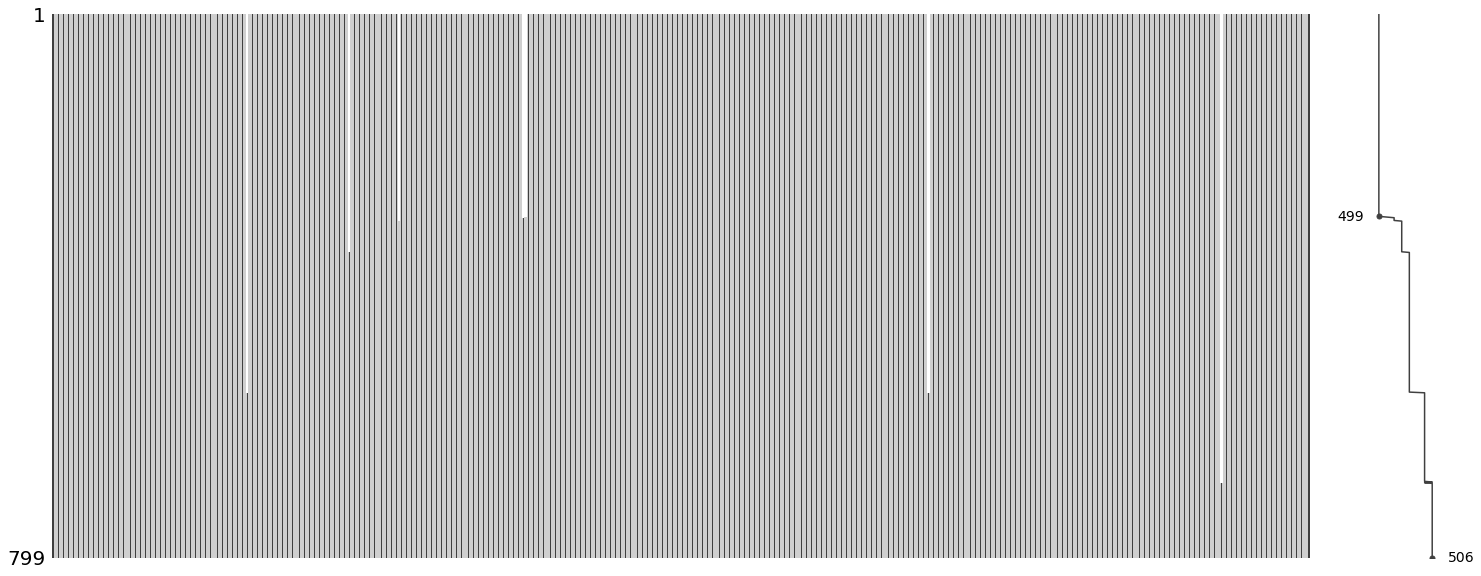

In [21]:
import missingno
missingno.matrix(data)

In [22]:
print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (799, 506)
Data Shape after cleaning = (799, 499)


In [23]:
data = data.fillna(method='ffill')

In [28]:
import numpy as np

#Calculate returns and create a data frame
returns = data.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = data.pct_change().std()*np.sqrt(266)

data = returns
data.head()

,returns,volatility
A,0.226,0.305
AAL,-0.095,0.691
AAP,0.224,0.368
AAPL,0.415,0.360
ABBV,0.128,0.331


In [29]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
A,0.282,-0.804
AAL,-1.858,3.010
AAP,0.271,-0.175
AAPL,1.546,-0.259
ABBV,-0.368,-0.544


In [6]:
#X.to_csv('cluster_scaled_2')

2. k-Means Clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

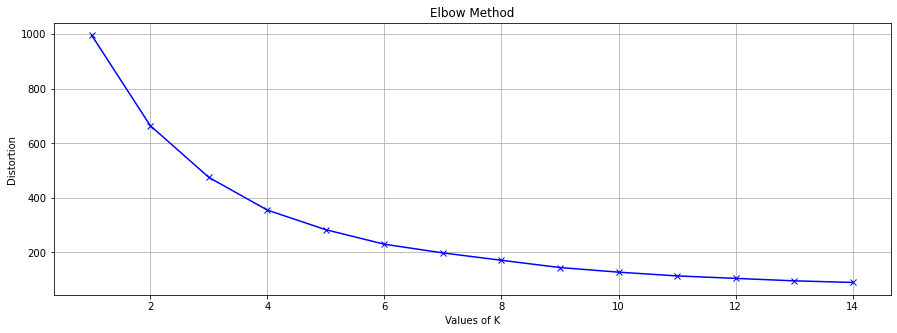

In [11]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    inertia[k] = kmeanModel.inertia_
    
#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [17]:
#pip install kneed
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

5

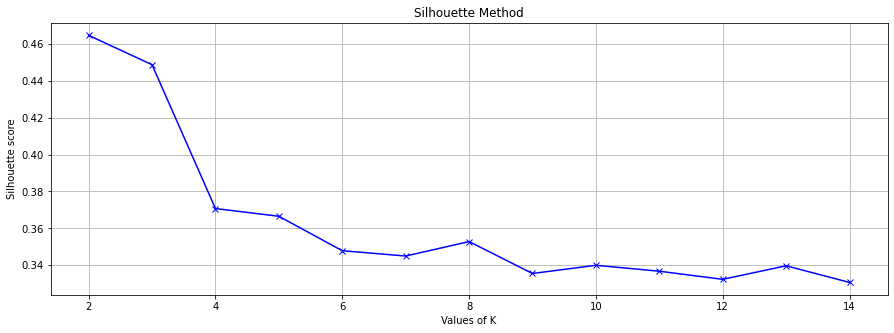

Suggested number of clusters:  6


In [22]:
from sklearn.metrics import silhouette_score

K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

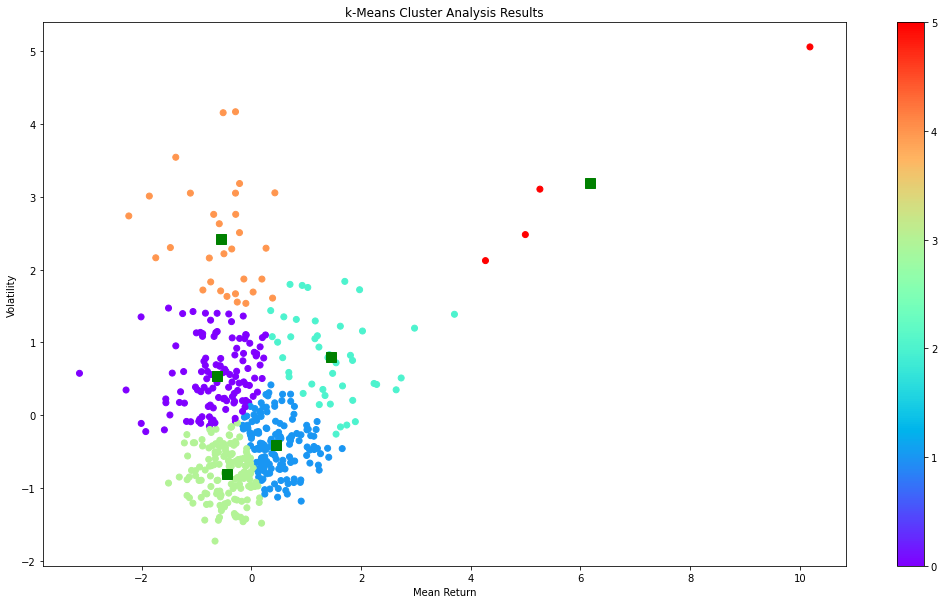

In [68]:
c = 6
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

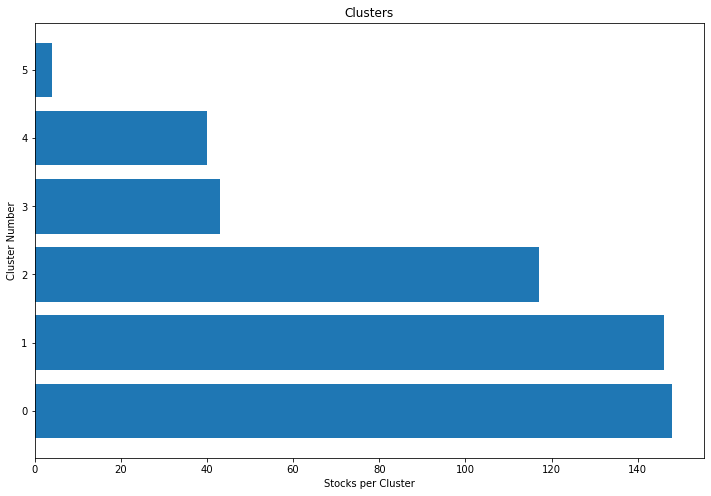

In [29]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [30]:
X

,returns,volatility
A,0.282,-0.804
AAL,-1.858,3.010
AAP,0.271,-0.175
AAPL,1.546,-0.259
ABBV,-0.368,-0.544
...,...,...
YUM,-0.295,-0.878
ZBH,-0.278,-0.386
ZBRA,2.733,0.512
ZION,-0.310,0.299


3. Hierarchical Clustering

In [31]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

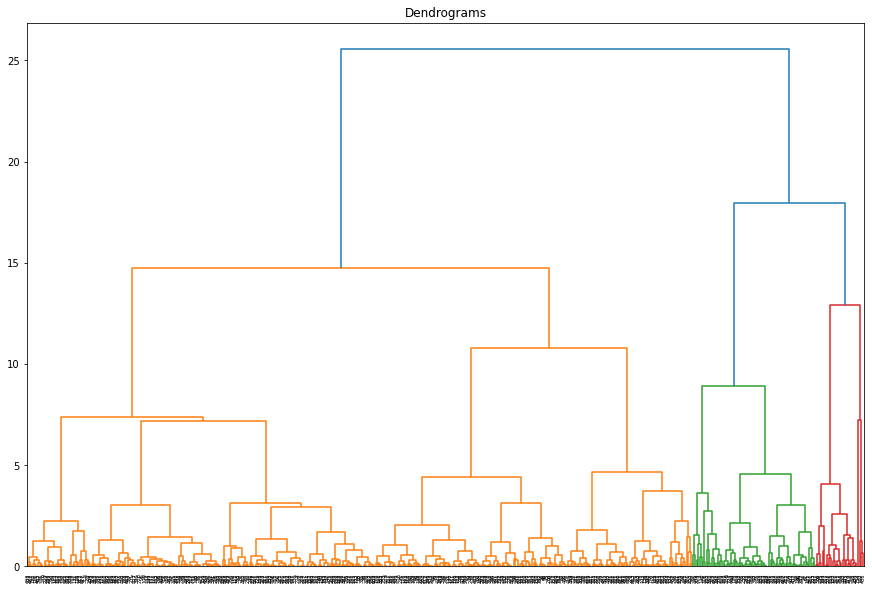

In [48]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

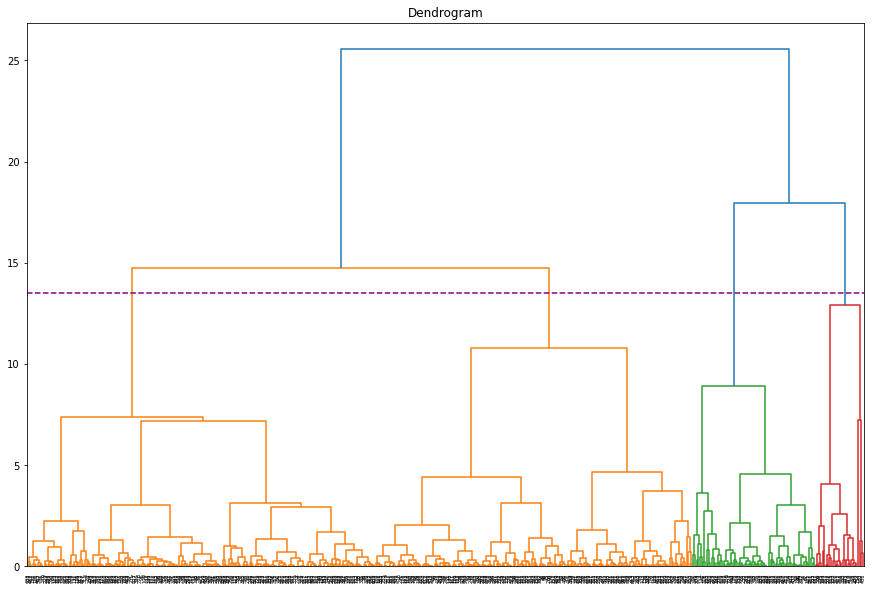

In [53]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=13.5, color='purple', linestyle='--')

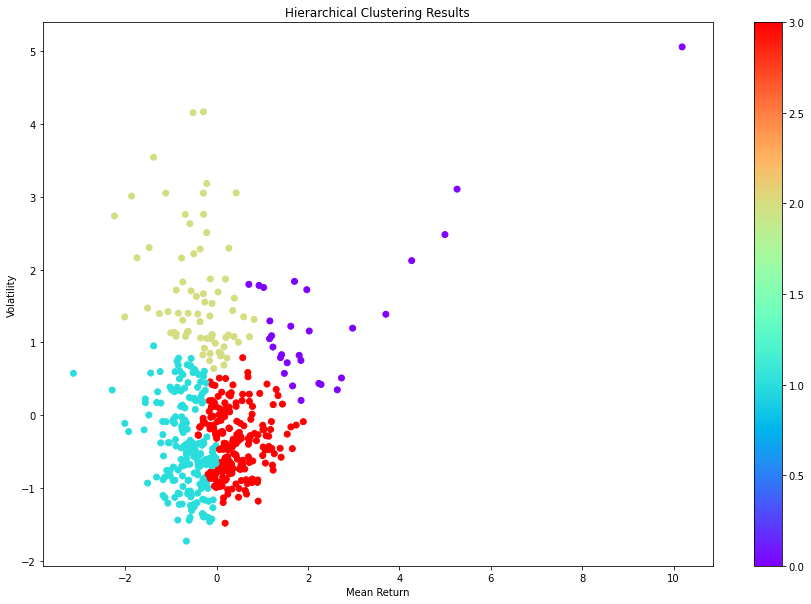

In [57]:
#Fit the model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

C:\Users\igorr\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


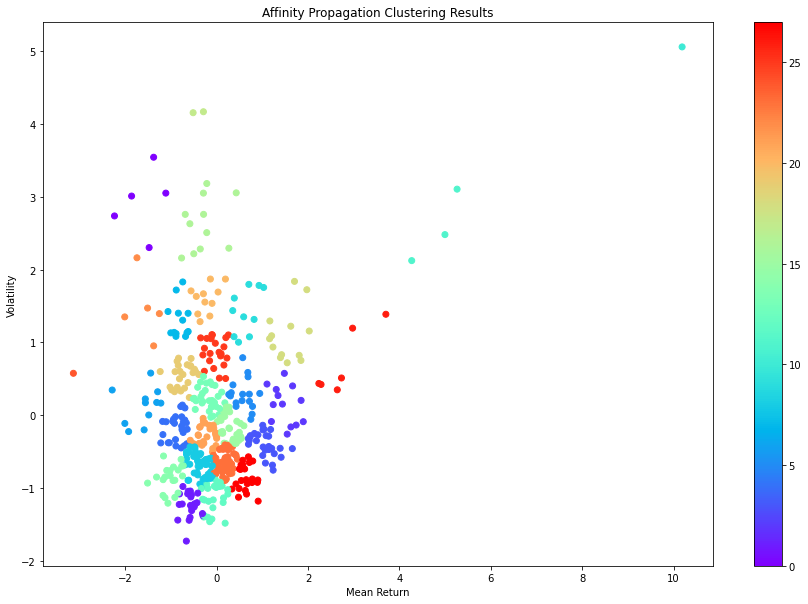

In [59]:
from sklearn.cluster import AffinityPropagation

#Fit the model
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 28


<Figure size 432x288 with 0 Axes>

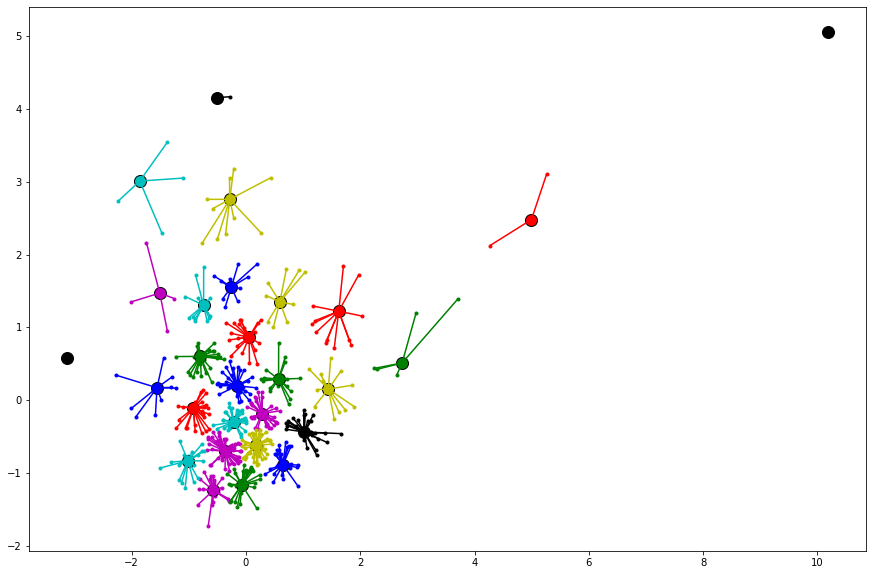

In [67]:
from itertools import cycle

cci = ap.cluster_centers_indices_
labels2 = ap.labels_

clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

In [69]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.3494916268886619
Hierarchical Clustering 0.3046193567096882
Affinity Propagation Clustering 0.33752158556435613


In [75]:
data1 = pd.read_csv('S&P500_stock_data')

In [81]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 6
Number of Pairs: 59876


In [84]:
def find_coint_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [86]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(data1[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 20
In those pairs, we found 25 unique tickers.
[('A', 'AVGO'), ('A', 'CMI'), ('A', 'DHI'), ('A', 'HOLX'), ('A', 'ISRG'), ('A', 'NKE'), ('A', 'ORCL'), ('A', 'TGT'), ('A', 'TMUS'), ('A', 'UNH'), ('ABBV', 'ABC'), ('ABBV', 'JBHT'), ('ABBV', 'NI'), ('AFL', 'HAS'), ('AFL', 'KIM'), ('AAPL', 'ADSK'), ('AAPL', 'CTLT'), ('AAPL', 'QRVO'), ('AAL', 'FANG'), ('AAL', 'UNM')]


In [93]:
pairs

[('A', 'AVGO'),
 ('A', 'CMI'),
 ('A', 'DHI'),
 ('A', 'HOLX'),
 ('A', 'ISRG'),
 ('A', 'NKE'),
 ('A', 'ORCL'),
 ('A', 'TGT'),
 ('A', 'TMUS'),
 ('A', 'UNH'),
 ('ABBV', 'ABC'),
 ('ABBV', 'JBHT'),
 ('ABBV', 'NI'),
 ('AFL', 'HAS'),
 ('AFL', 'KIM'),
 ('AAPL', 'ADSK'),
 ('AAPL', 'CTLT'),
 ('AAPL', 'QRVO'),
 ('AAL', 'FANG'),
 ('AAL', 'UNM')]

In [94]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

,returns,volatility
A,0.282,-0.804
AAL,-1.858,3.010
AAPL,1.546,-0.259
ABBV,-0.368,-0.544
ABC,-0.503,-0.390


In [105]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)
X_tsne

array([[-16.739414  ,   6.035396  ],
       [ 12.596986  ,   5.8783464 ],
       [ -6.247481  , -11.191064  ],
       [  0.24466717,  19.624819  ],
       [  0.11503125,  16.733072  ],
       [ -1.1566514 , -10.205603  ],
       [  2.8713794 ,  15.464647  ],
       [ -0.89705896,  -1.4241827 ],
       [-13.004093  ,   8.288439  ],
       [ -3.0310671 ,  -8.433553  ],
       [  1.6520617 ,   0.7450683 ],
       [ 13.206991  ,   3.245121  ],
       [  4.1540318 ,  12.629815  ],
       [-11.530533  ,   5.560066  ],
       [ -3.6330476 ,  -0.18150683],
       [ -1.7050824 ,  21.48273   ],
       [  4.8245955 ,   3.479523  ],
       [ -4.1050615 ,  17.314945  ],
       [-15.419457  ,  -0.44524172],
       [-16.432728  ,   9.074506  ],
       [  1.8796498 , -10.26251   ],
       [ -8.51168   , -10.001729  ],
       [-16.490843  ,   2.3289223 ],
       [ -9.5742235 ,   7.428761  ],
       [  9.574745  ,   6.6323643 ]], dtype=float32)

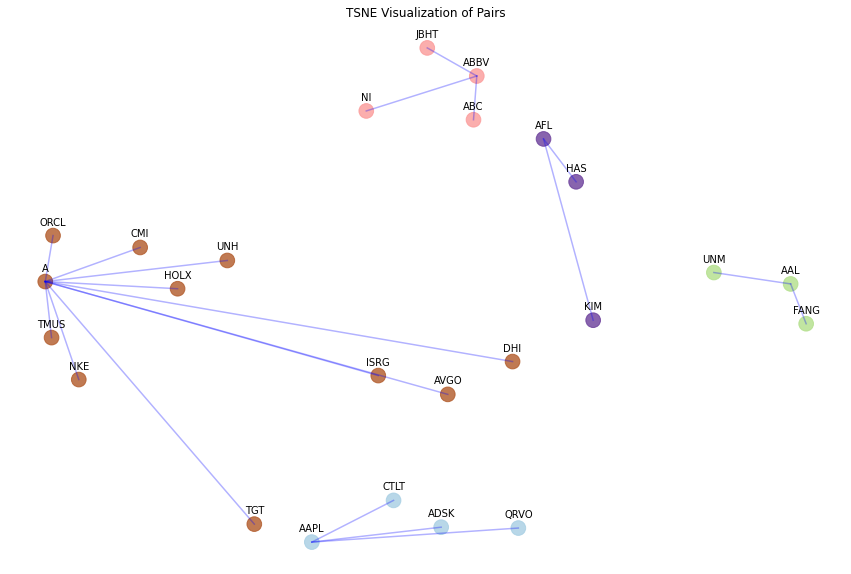

In [106]:
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()